In [ ]:
import random
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    torch.cuda.empty_cache()

Using device: cpu


# Data

In [3]:
# --- 1. Dataset with static + dynamic features ---
class VariableLengthSequenceDataset(Dataset):
    def __init__(self, num_samples=300, max_len=15, min_len=5,
                 dynamic_feat_dim=3, static_feat_dim=2, num_classes=4):
        self.samples = []
        for _ in range(num_samples):
            seq_len = random.randint(min_len, max_len)
            dynamic = torch.randn(seq_len, dynamic_feat_dim)
            static = torch.randn(static_feat_dim)
            label = random.choices(range(num_classes), weights=[0.6, 0.2, 0.15, 0.05])[0]  # imbalance
            self.samples.append((dynamic, static, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# --- 2. Collate function ---
def collate_batch(batch):
    dyn_seqs, stat_feats, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in dyn_seqs])
    padded_dyn = pad_sequence(dyn_seqs, batch_first=True)
    static_feats = torch.stack(stat_feats)
    labels = torch.tensor(labels)
    return padded_dyn, static_feats, lengths, labels

# --- 3. Model with LSTM + static ---
class LSTMWithStaticClassifier(nn.Module):
    def __init__(self, dynamic_feat_dim, static_feat_dim, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(dynamic_feat_dim, hidden_size, batch_first=True)
        self.classifier = nn.Linear(hidden_size + static_feat_dim, num_classes)

    def forward(self, x_dyn, x_static, lengths):
        packed_input = pack_padded_sequence(x_dyn, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_input)
        last_hidden = h_n[-1]  # final hidden for each sequence
        combined = torch.cat([last_hidden, x_static], dim=1)
        return self.classifier(combined)

In [4]:
# --- 4. Data prep ---
dynamic_feat_dim = 3 # fixed by data
static_feat_dim = 2  # fixed by data
hidden_size = 64     # hyperparameter
num_classes = 4      # fixed by data
batch_size = 16
epochs = 10          # hyperparameter

dataset = VariableLengthSequenceDataset(dynamic_feat_dim=dynamic_feat_dim, static_feat_dim=static_feat_dim, num_classes=num_classes)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Model

In [ ]:
# --- 5. Compute class weights ---
all_train_labels = [label for _, _, label in train_ds]
label_counts = Counter(all_train_labels)
total = sum(label_counts.values())
class_weights = torch.tensor([total / label_counts[i] for i in range(num_classes)], dtype=torch.float).to(device)

# --- 6. Model and loss ---
model = LSTMWithStaticClassifier(dynamic_feat_dim, static_feat_dim, hidden_size, num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 7. Evaluation helper ---
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_dyn, x_static, lengths, y in dataloader:
            x_dyn = x_dyn.to(device)
            x_static = x_static.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            logits = model(x_dyn, x_static, lengths)
            pred = logits.argmax(dim=1)
            all_preds.extend(pred.tolist())
            all_labels.extend(y.tolist())
            correct += (pred == y).sum().item()
            total += len(y)
    return correct / total, all_preds, all_labels

# Training

In [6]:
# --- 8. Training loop ---
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_dyn, x_static, lengths, y in train_loader:
        x_dyn = x_dyn.to(device)
        x_static = x_static.to(device)
        lengths = lengths.to(device)
        y = y.to(device)

        logits = model(x_dyn, x_static, lengths)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(y)

    train_acc, _, _ = evaluate(model, train_loader)
    test_acc, test_preds, test_labels = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Loss: {total_loss / train_size:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1, Loss: 1.3880, Train Acc: 0.2042, Test Acc: 0.2333
Epoch 2, Loss: 1.3771, Train Acc: 0.2250, Test Acc: 0.2500
Epoch 3, Loss: 1.3682, Train Acc: 0.2583, Test Acc: 0.2500
Epoch 4, Loss: 1.3663, Train Acc: 0.2750, Test Acc: 0.2333
Epoch 5, Loss: 1.3535, Train Acc: 0.3458, Test Acc: 0.2333
Epoch 6, Loss: 1.3496, Train Acc: 0.4375, Test Acc: 0.3333
Epoch 7, Loss: 1.3513, Train Acc: 0.4042, Test Acc: 0.3500
Epoch 8, Loss: 1.3292, Train Acc: 0.4250, Test Acc: 0.3333
Epoch 9, Loss: 1.3323, Train Acc: 0.5250, Test Acc: 0.4167
Epoch 10, Loss: 1.3311, Train Acc: 0.4583, Test Acc: 0.3333


# Evaluation

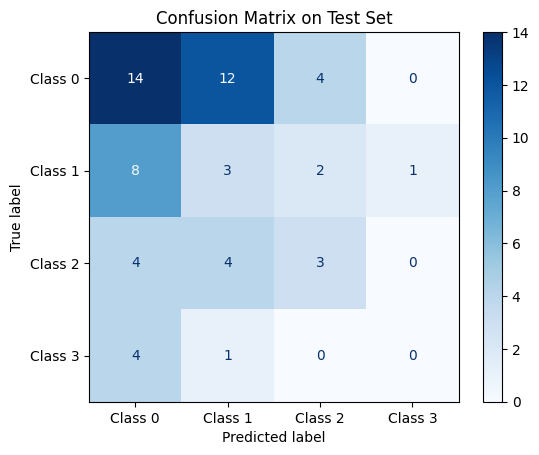

In [7]:
# --- 9. Confusion matrix ---
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(num_classes)])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Hyperarameter tuning
## Optuna

In [8]:
import optuna

/home/wei-chih/Downloads/temp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def objective(trial):
    # hyparameters
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    # num_layers = trial.suggest_int('num_layers', 1, 2)

    model = LSTMWithStaticClassifier(
        dynamic_feat_dim=3,
        static_feat_dim=2,
        hidden_size=hidden_size,
        num_classes=4
    )
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # TODO: change epochs
    for epoch in range(5):
        model.train()
        for x_dyn, x_static, lengths, y in train_loader:
            x_dyn = x_dyn.to(device)
            x_static = x_static.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            logits = model(x_dyn, x_static, lengths)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # --- Validation Accuracy (return to Optuna) ---
    val_acc, _, _ = evaluate(model, test_loader)
    return val_acc

# --- Run the study ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=False, gc_after_trial=True)

# --- Best results ---
print("\nBest parameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

[I 2025-07-04 19:45:21,955] A new study created in memory with name: no-name-35918fbc-bf29-4bda-8169-96f29c1fe4de
[I 2025-07-04 19:45:22,509] Trial 0 finished with value: 0.31666666666666665 and parameters: {'hidden_size': 64, 'lr': 0.0057375131842667204}. Best is trial 0 with value: 0.31666666666666665.
[I 2025-07-04 19:45:23,027] Trial 1 finished with value: 0.2 and parameters: {'hidden_size': 32, 'lr': 0.00016355040086167566}. Best is trial 0 with value: 0.31666666666666665.
[I 2025-07-04 19:45:23,674] Trial 2 finished with value: 0.5333333333333333 and parameters: {'hidden_size': 128, 'lr': 0.0018699524265655696}. Best is trial 2 with value: 0.5333333333333333.
[I 2025-07-04 19:45:24,337] Trial 3 finished with value: 0.36666666666666664 and parameters: {'hidden_size': 64, 'lr': 0.007345223419295273}. Best is trial 2 with value: 0.5333333333333333.
[I 2025-07-04 19:45:24,851] Trial 4 finished with value: 0.35 and parameters: {'hidden_size': 32, 'lr': 0.0019351422361663527}. Best is 


Best parameters: {'hidden_size': 128, 'lr': 0.0018699524265655696}
Best validation accuracy: 0.5333333333333333


save to file

In [10]:
trials_results = study.trials_dataframe().sort_values(by='value', ascending=False)
trials_results.to_csv('optuna_trials.csv', index=False)